## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator,load_img

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from keras.optimizers import Adam,RMSprop
from keras.losses import BinaryCrossentropy
from keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping
import os

## Loading Data & Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
input_path = '/content/drive/MyDrive/chest_xray/'

counter_normal_train = len(os.listdir(input_path + 'train' + '/NORMAL'))
counter_infect_train = len(os.listdir(input_path + 'train' + '/PNEUMONIA'))

counter_normal_test = len(os.listdir(input_path + 'test' + '/NORMAL'))
counter_infect_test = len(os.listdir(input_path + 'test' +  '/PNEUMONIA'))

counter_normal_val = len(os.listdir(input_path + 'val' + '/NORMAL'))
counter_infect_val = len(os.listdir(input_path + 'val' +  '/PNEUMONIA'))

counter_all = counter_normal_train + counter_infect_train + counter_normal_test + counter_infect_test + counter_normal_val +  counter_infect_val
counter_all_healthy = counter_normal_train + counter_normal_test + counter_normal_val
counter_all_infect = counter_infect_train + counter_infect_test + counter_infect_val

In [ ]:
number_of_normal_img = counter_all_healthy
number_of_pneumonia_img = counter_all_infect
print("number of normal images:", number_of_normal_img)
print("number of pneumonia images:", number_of_pneumonia_img)

number of normal images: 1613
number of pneumonia images: 4370


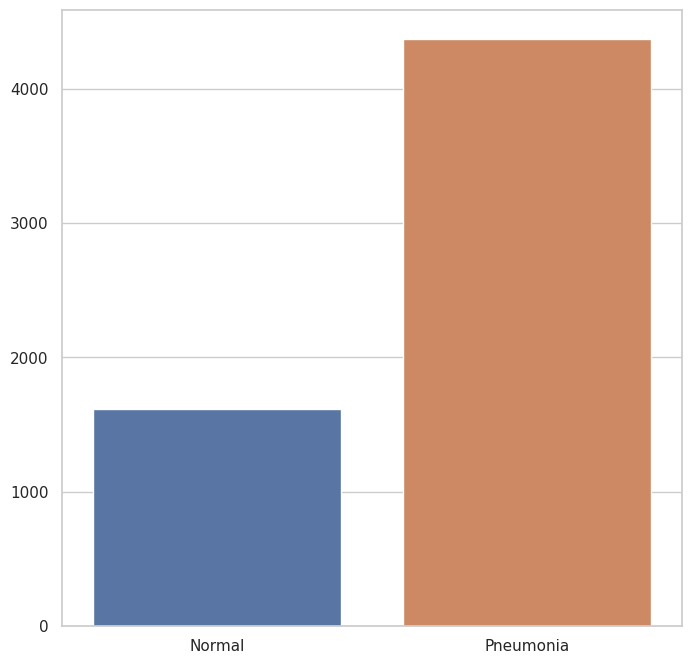

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (8,8))
ax = sns.barplot( x = ["Normal", "Pneumonia"], y = [number_of_normal_img, number_of_pneumonia_img])

## Data Visualization

## Data Augmentation

In [ ]:
train_val_generator = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.3)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train = train_val_generator.flow_from_directory(input_path + 'train',
                                               batch_size=128,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")



Found 5303 images belonging to 2 classes.


In [ ]:
val = train_val_generator.flow_from_directory(directory = input_path + 'val',
                                               batch_size=4,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 16 images belonging to 2 classes.


In [ ]:
test = test_generator.flow_from_directory(directory = input_path + 'test',
                                          batch_size=32,
                                          target_size=(220,220),
                                          color_mode="rgb",
                                          class_mode="binary")

Found 664 images belonging to 2 classes.


## Deep Residual Network (ResNet)

In [ ]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet50.layers:
    layer.trainable = False

In [ ]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False

model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))


## Compining the Model

In [ ]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,410,113
Trainable params: 12,845,313
Non-trainable params: 23,564,800
_________________________________________________________________


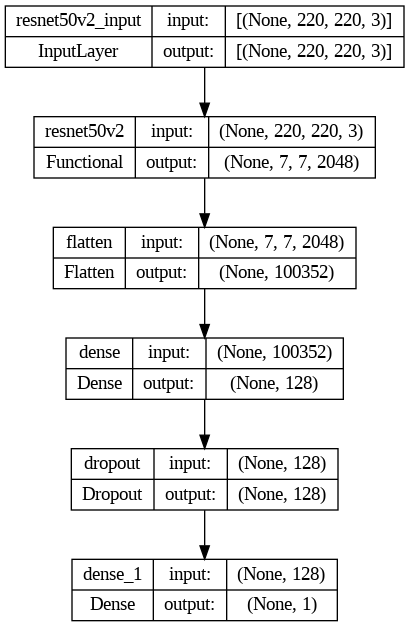

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model1.png', show_layer_names=True, show_shapes=True)



In [ ]:

import time

start_time = time.time()
hist = model.fit(train,validation_data=test,epochs=11)
model.save("originaldataset_resnet50kaggle.h5")

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total training time: {elapsed_time} seconds")


Epoch 1/11
42/42 [==============================] - 1842s 43s/step - loss: 1.1497 - accuracy: 0.8610 - val_loss: 0.2697 - val_accuracy: 0.9081
Epoch 2/11
42/42 [==============================] - 1266s 30s/step - loss: 0.1779 - accuracy: 0.9300 - val_loss: 0.2698 - val_accuracy: 0.9066
Epoch 3/11


## Evaluate the Model

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(hist.history['loss'], color='b', label="Training loss")
plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(6,6))
plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc = "lower right")
plt.show()

In [ ]:
test_results = model.evaluate()

ValueError: ignored

In [ ]:
def process_images(dimensions):


  test_data = []
  test_labels = []

  for condition in ['/NORMAL/', '/PNEUMONIA/']:
    for image in (os.listdir(input_path + 'test' + condition)):
      image = plt.imread(input_path + 'test' + condition + image)
      image = cv2.resize(image, (dimensions, dimensions))
      image = np.dstack([image, image, image])
      image = image.astype('float32') / 255
      if condition == '/NORMAL/':
        label = 0
      elif condition == '/PNEUMONIA/':
        label = 1


      test_data.append(image)
      test_labels.append(label)

  test_data = np.array(test_data)
  test_labels = np.array(test_labels)

  return test_data, test_labels


In [ ]:
test_data, test_labels = process_images(220)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

predict_probs = model.predict(test_data)
#predict_classes = model.predict_classes(test_data, verbose=0)
print(predict_probs)

# Calculate predicted classes using the predicted probabilities (assuming a threshold of 0.5)
predict_classes = np.round(predict_probs)
predict_classes = np.array(predict_classes).reshape(test_labels.shape).astype(int)

print("Test labels", test_labels)
print("Predict classes", predict_classes)


print ('\nTest metrics\n----------------')
cm = confusion_matrix(test_labels, predict_classes)
print ('Confusion matrix\n', cm)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, predict_classes) * 100
print('Accuracy: {}%'.format(np.round(accuracy,2)))
# precision tp / (tp + fp)
precision = precision_score(test_labels, predict_classes) * 100
print('Precision: {}%'.format(np.round(precision,2)))
# recall: tp / (tp + fn)
recall = recall_score(test_labels, predict_classes) * 100
print('Recall: {}%'.format(np.round(recall,2)))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, predict_classes) * 100
print('F1-score: {}%'.format(np.round(2* precision * recall / (precision + recall),2)))

auc = roc_auc_score(test_labels, predict_probs)
print('ROC AUC: %f' % auc)

print('\nTrain metric\n----------------')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

21/21 [==============================] - 7s 148ms/step
[[4.10775747e-03]
 [1.48848665e-03]
 [1.14916598e-04]
 [1.29585359e-02]
 [8.67065787e-02]
 [1.55706033e-02]
 [6.86082989e-03]
 [3.45319495e-05]
 [1.64634286e-04]
 [1.09027550e-02]
 [6.08766405e-03]
 [1.59253236e-02]
 [1.35044800e-03]
 [3.14434141e-01]
 [7.53039858e-05]
 [1.43907910e-05]
 [1.64361432e-01]
 [2.07011425e-03]
 [1.66252479e-01]
 [9.39642196e-04]
 [3.83735809e-04]
 [7.30685294e-02]
 [1.48431236e-05]
 [4.49213564e-01]
 [1.06743864e-05]
 [7.52649307e-01]
 [1.95167661e-02]
 [4.39390093e-02]
 [4.42421529e-03]
 [8.82970989e-02]
 [1.65029280e-02]
 [9.99956012e-01]
 [3.37456875e-02]
 [5.89229213e-03]
 [1.87508650e-02]
 [1.39508806e-02]
 [4.42882162e-03]
 [3.43791544e-02]
 [2.20806412e-02]
 [5.24943601e-03]
 [4.01609652e-02]
 [4.40035147e-10]
 [1.72914832e-03]
 [2.30850428e-01]
 [1.30994946e-01]
 [9.76755857e-01]
 [2.80329641e-05]
 [1.59851126e-02]
 [8.46381858e-02]
 [2.57281167e-03]
 [1.25695899e-01]
 [1.02938093e-01]
 [2.29264